# 3. Pruning Crossvalidation

In [ ]:
# import libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

In [3]:
# generate synthetic data
x = np.linspace(start = 0, stop = 2 * np.pi, num=500)
m = 2 * np.sin(x)
y = m + np.random.normal(loc = 0, scale = 1, size = len(x))

In [8]:
# adding column name to array (and transforming it into pd.DataFrame)
x = pd.DataFrame({'feature_1':x})
y = pd.DataFrame({'y':y})

In [98]:
# fit a very deep tree
deep_tree = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = 0).fit(x, y)
y_deep_tree = deep_tree.predict(x)

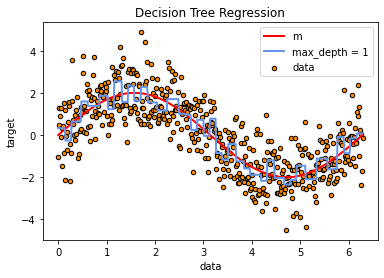

In [99]:
# Plot deep_tree
plt.figure()
plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data") # plot raw data (including stoch. desturbance)
plt.plot(x, m, color="red", label="m", linewidth=2) # plot raw data (excluding stoch. desturbance)
plt.plot(x, y_deep_tree, color="cornflowerblue", label="max_depth = 1", linewidth=2) # depth 1
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### 3.1 Impurity of leaves vs effective alphas of pruned tree

In [78]:
scores = cross_val_score(deep_tree, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-0.40 accuracy with a standard deviation of 0.42


In [76]:
scores

array([-1.19826948, -0.28592263,  0.01667789, -0.13215533, -0.40931967])

In [70]:
path = deep_tree.cost_complexity_pruning_path(x, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

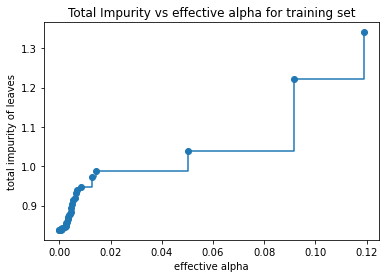

In [71]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

<AxesSubplot:xlabel='node_counts'>

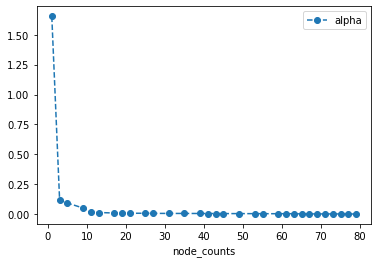

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    regr_dt = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = ccp_alpha).fit(x, y)
    
    dt_scores = cross_val_score(regr_dt, x, y, cv = 5)
    
    predictions = regr_dt.predict(x)
    mse = mean_squared_error(y,predictions)
    mae = mean_absolute_error(y,predictions)
    node_counts = regr_dt.tree_.node_count
    depth = regr_dt.tree_.max_depth
    
    alpha_loop_values.append([ccp_alpha, node_counts, depth,
                              np.mean(dt_scores), regr_dt.score(x,y), r2_score(y, predictions),
                              np.mean(mse), np.mean(mae)])
              
alpha_results = pd.DataFrame(alpha_loop_values, 
                         columns=['alpha', 'node_counts', 'depth',
                                  'r2_scores', 'r2_score_nocv', 'r2_pred_orig',
                                  'mean_squared_error', 'mean_absolute_error'])

alpha_results.plot(x='node_counts', y='alpha', marker='o', linestyle='--')

In [91]:
alpha_results

,alpha,node_counts,depth,r2_scores,r2_score_nocv,r2_pred_orig,mean_squared_error,mean_absolute_error
0,0.000000,79,9,-0.401798,0.720163,0.720163,0.838265,0.725144
1,0.000018,77,9,-0.401798,0.720157,0.720157,0.838283,0.725058
2,0.000507,75,9,-0.401798,0.719987,0.719987,0.838790,0.724842
3,0.000554,73,9,-0.401798,0.719802,0.719802,0.839344,0.725429
4,0.000619,71,9,-0.401798,0.719596,0.719596,0.839963,0.724783
5,0.000752,69,9,-0.401798,0.719345,0.719345,0.840715,0.725196
6,0.000957,67,9,-0.401798,0.719025,0.719025,0.841672,0.725196
7,0.001076,65,9,-0.401798,0.718666,0.718666,0.842748,0.725471
8,0.002354,63,9,-0.401798,0.717880,0.717880,0.845102,0.726345
9,0.002381,61,9,-0.401798,0.717086,0.717086,0.847483,0.727256


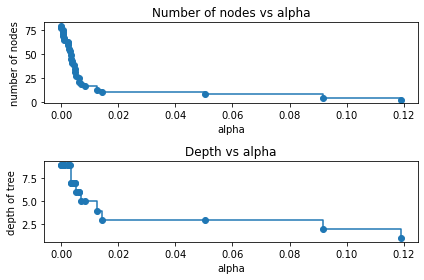

In [34]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [13]:
from sklearn.model_selection import cross_val_score
dt_scores = cross_val_score(deep_tree, x, y, cv=5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(deep_tree.score(x, y)))

mean cross validation score: -0.401797844020249
score without cv: 0.7201626871749827


In [ ]:
# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))